Progetto Modelli Biologici Discreti
Analisi pangenomica di k-mer in microorganismi

Selezione dei genomi ed estrazione dei pangenomi

Lettura delle sequenze.

In [17]:
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
from pprint import pprint
from mialibreria import *

def lettura_sequenze(primo):
    lista=os.listdir(primo)
    sequenze_primo=[]

    for file in lista:
        if os.path.isfile(primo+file):
            stringhe=leggi_sequenze_fasta(primo+file)
            sequenze_primo.append(stringhe[0])    
            #pprint((stringhe[0][:100].upper()))
    return sequenze_primo
            

In [18]:

def rimozione_simboli(sequenza):
    sequenza=sequenza.upper()
    #convertiamo la stringa in lista
    sequenza=list(sequenza)
    for i in range(len(sequenza)):
        if sequenza[i]=='T':
            sequenza[i]='U'
        elif sequenza[i]=='R':
            sequenza[i]='A'
        elif sequenza[i]=='Y':
            sequenza[i]='C'
        elif sequenza[i]=='S':
            sequenza[i]='G'
        elif sequenza[i]=='W':
            sequenza[i]='A'
        elif sequenza[i]=='K':
            sequenza[i]='G'
        elif sequenza[i]=='M':
            sequenza[i]='A'
        elif sequenza[i]=='B':
            sequenza[i]='C'
        elif sequenza[i]=='D':
            sequenza[i]='A'
        elif sequenza[i]=='H':
            sequenza[i]='A'
        elif sequenza[i]=='V':
            sequenza[i]='A'
        elif sequenza[i]=='.' or sequenza[i]=='-':
            sequenza[i]='N'
            
    #convertiamo la lista in stringa        
    sequenza=''.join(sequenza)
    return sequenza 

In [19]:
def estraikmeri_comuni(lista_sequenze,k):
    lista_kmeri=set()
    lista=[]
    for sequenza in lista_sequenze:
        sequenza=rimozione_simboli(sequenza)
        kmeri=estrai_kmeri(sequenza,k)
        #aggiunge al set non duplicati
        lista_kmeri.update(kmeri)
        #aggiunge set k-meri alla lista
        lista.append(kmeri)
    return lista_kmeri,lista

In [20]:
def calcola_diffusivita(lista_kmeri,lista):
    di_diff={}
    for kmero in lista_kmeri:
        diff=0
        for lk in lista:
            if kmero in lk:
                diff+=1
        di_diff[kmero]=diff
    return di_diff 


In [21]:
#numero di k-meri che hanno una data diffusività
def calcola_codiff(di_diff):
    co_diff={}
    for _,v in di_diff.items():
        #chiave,valore sostitutivo, se valore associato alla chiave va bene, se no restituisce 0
        co_diff[v]=co_diff.get(v,0)+1
            
    return co_diff

In [22]:
#dati 2 k-meri random calcola la probabilità che essi abbiano lo stesso valore di co-diffusività
def calcola_simpson(codif):
    N=0
    #Sum n(n-1)
    Numerator=0
    for n in codif.values():
        N+=n
        Numerator+=n*(n-1)
    return 1-(Numerator/(N*(N-1)))

In [23]:
def calcola_k(lista_sequenze):
    min_k=6
    somma=0
    for sequenza in lista_sequenze:
        somma+=len(sequenza)
  
    max_k=2*math.log(somma,4)+1
    max_k=round(max_k)
    
    return min_k,max_k

In [24]:
def estrai_posizioni(s, w):
    """
    Calcola le posizioni in s da dove parte ogni occorrenza della parola w.
    La lista delle posizioni restituita è ordinata.
    """
    posizioni = list()
    for i in range(len(s) - len(w) + 1):
        if s[i:i+len(w)] == w:
            posizioni.append(i)
    return posizioni

#insieme posizioni, qui valore copertura, numero posizioni coperte
def copertura_sequenza(s, D):
    """
    Calcola la copertura di sequenza
    """
    cop = [ 0 for i in range(len(s)) ]
    for w in D:
        posizioni = estrai_posizioni(s,w)
        for p in posizioni:
            for i in range(len(w)):
                cop[p+i] = 1
    return sum(cop)
    

In [25]:
#numero parole su tale posizione
def copertura_posizionale(s, D):
    """
    Calcola la copertura di sequenza
    """
    cop = [ 0 for i in range(len(s)) ]
    for w in D:
        posizioni = estrai_posizioni(s,w)
        for p in posizioni:
            for i in range(len(w)):
                cop[p+i] += 1
    return cop

In [26]:
def estrai_pcov_distr(s, D):
    copertura = copertura_posizionale(s,D)
    #print(f"Copertura posizionale:{copertura}")
    distr = dict()
    for v in copertura:
        distr[v] = distr.get(v,0) + 1
    return distr


In [27]:
def visualizza_copertura(s,D):
    
    pcovd = estrai_pcov_distr(s,D)

    x = [k for k,v in sorted(pcovd.items())]
    y = [v for k,v in sorted(pcovd.items())]

    plt.figure(figsize=(15,5))
    visualizza_distr(x, y, xlabel="copertura posizionale", ylabel="numero di posizioni", xticks=x, title=None, specie=None)

In [28]:
#grafico
def visualizza_co_diff(specie,lista_sequenze):
    print(specie)
    
    min_k,max_k=calcola_k(lista_sequenze)
    if not os.path.exists(f"./immagini/{specie}"):
        os.mkdir(f"./immagini/{specie}")
    dic_codif={}
    #fig,axs=plt.subplots(int((max_k-min_k)/4),4, sharex=True, sharey=True)
    for k in range(min_k,max_k+1):
        kmeri_comuni,tutti_kmeri=estraikmeri_comuni(lista_sequenze,k)
        di_diff=calcola_diffusivita(kmeri_comuni,tutti_kmeri)
        co_diff=calcola_codiff(di_diff)
        dic_codif[k]=co_diff
        visualizza_distr(co_diff.keys(),co_diff.values(), "numero genomi", "co-diffusività", None, f"k={k}", specie)
    return dic_codif
    

In [29]:
def genera_df_simpson(dic_codif, name):
    dic_simpson={}
    #dato dizionario codiff, calcola valore simpson di tale distribuzione
    for k,co_diff in dic_codif.items():
        dic_simpson[k]=calcola_simpson(co_diff)
    df=pd.Series(dic_simpson, name=name).to_frame()
    df.index.name="k"
    return df

In [30]:
def genera_dizionario(k):
    return [genera_random_noseed(k) for _ in range(10)]

Apicomplexa


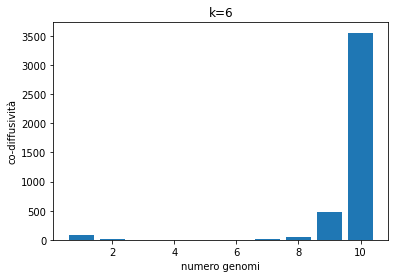

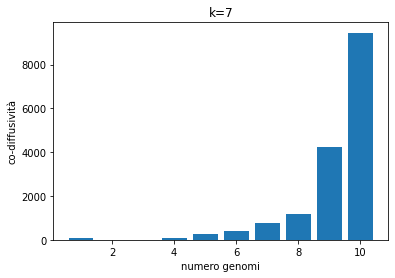

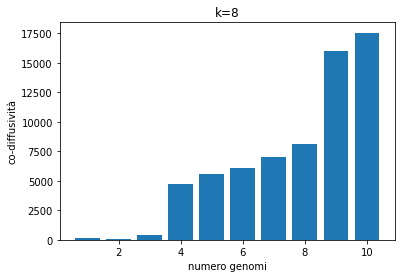

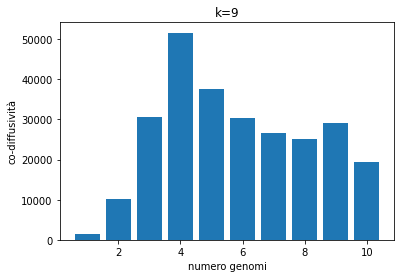

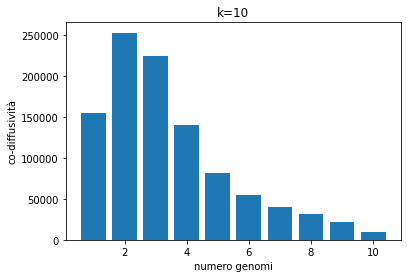

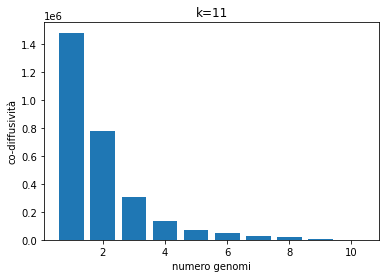

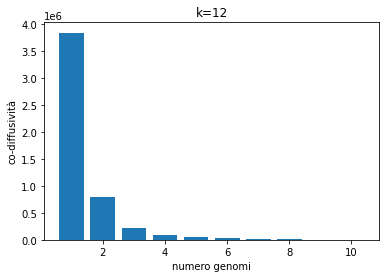

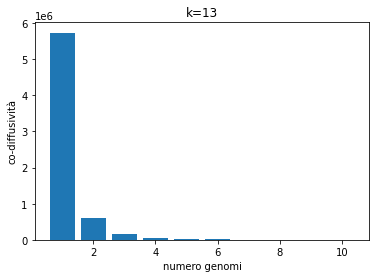

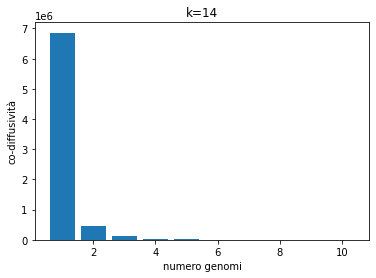

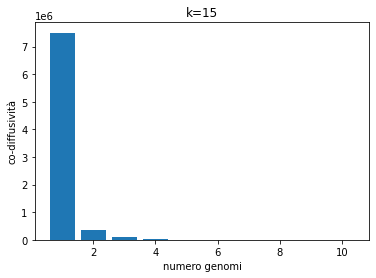

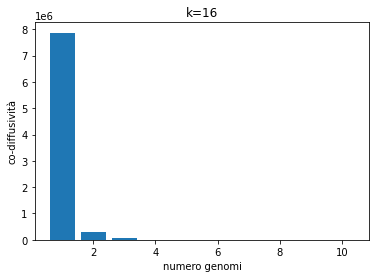

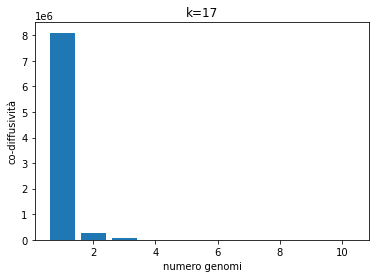

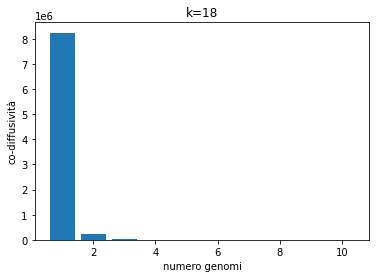

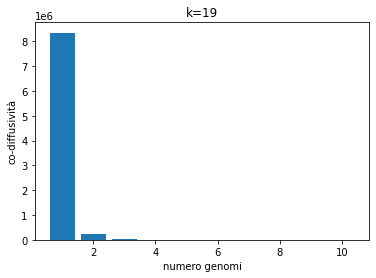

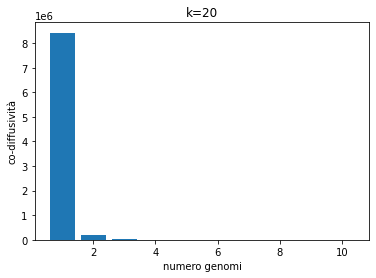

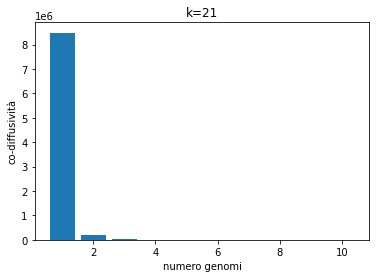

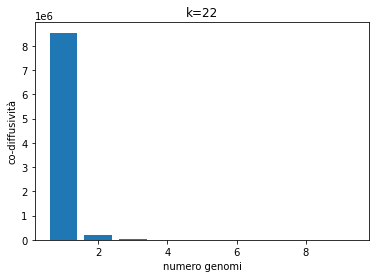

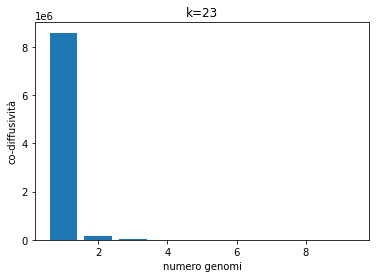

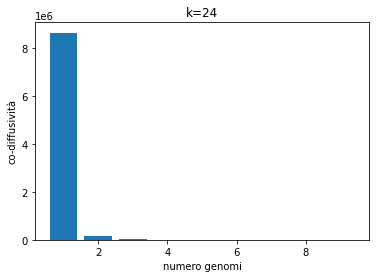

dizionario: TCC,AGC,TTA,CCC,ATA,GGA,AGA,CAT,CGA,ACA
Numero di posizioni coperte: 299370
Rapporto di copertura: 0.38945529336311563
Percentuale di copertura: 38.945529336311566%


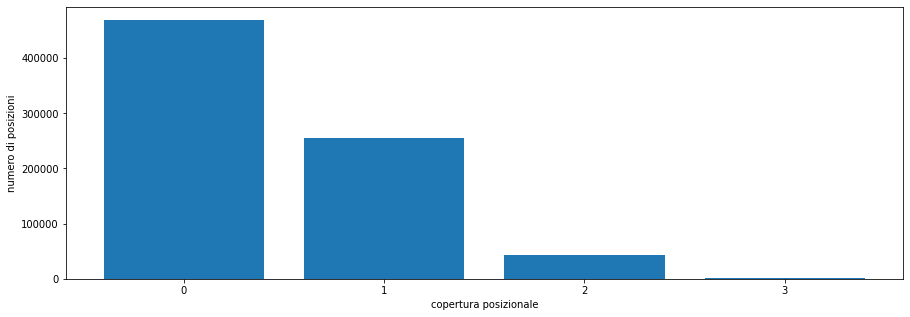

********************************************************************************
Ciliophora


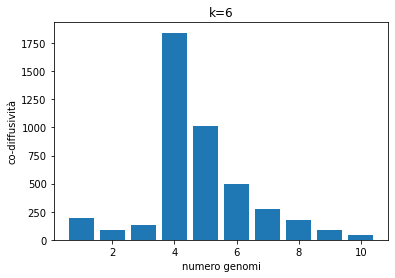

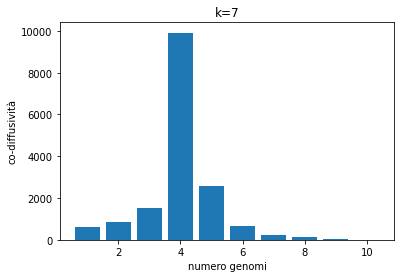

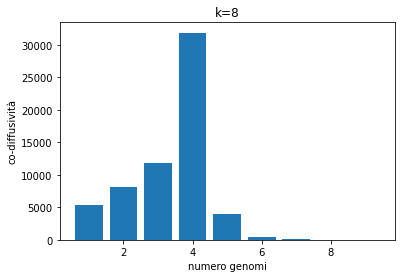

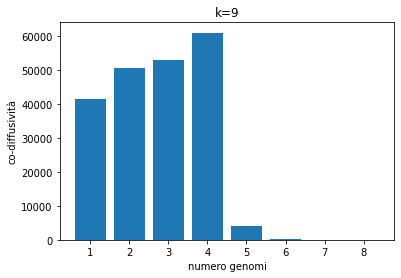

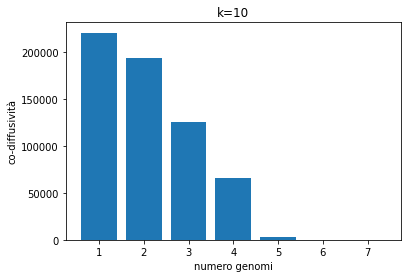

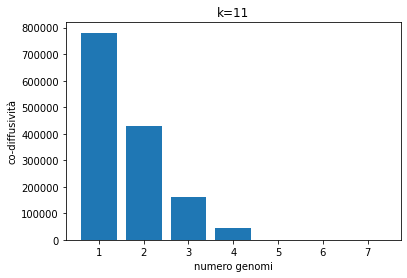

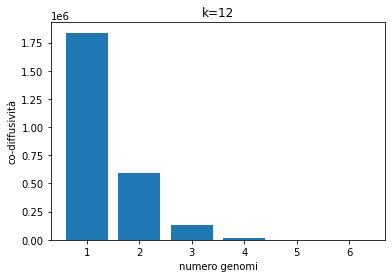

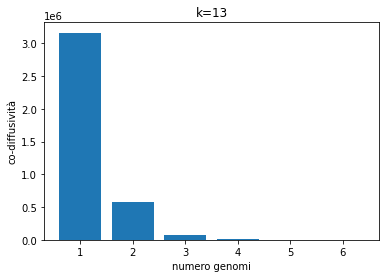

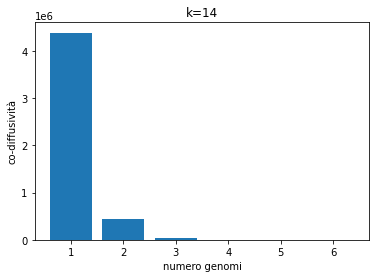

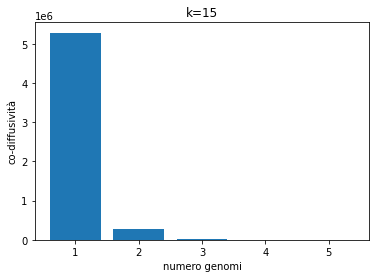

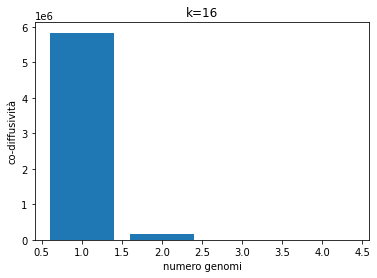

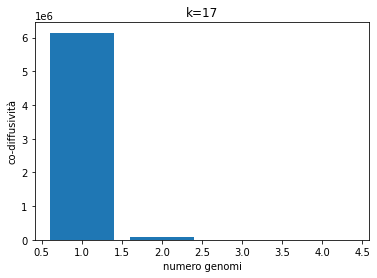

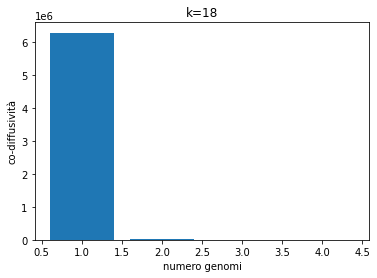

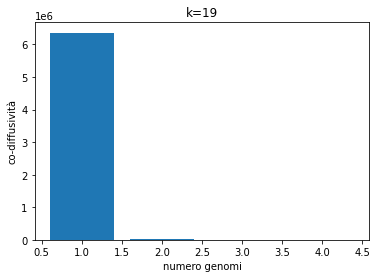

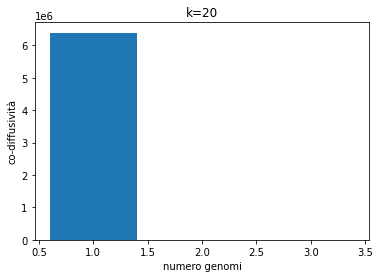

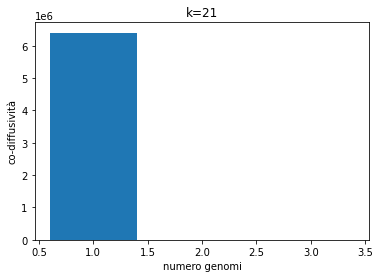

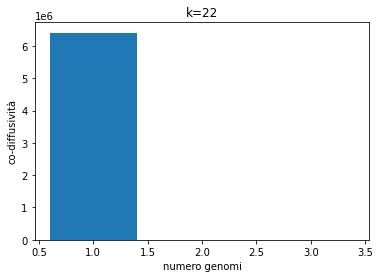

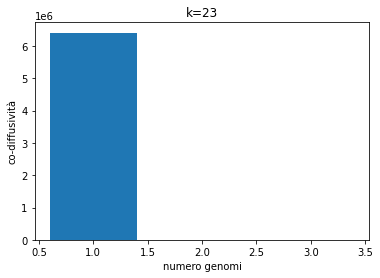

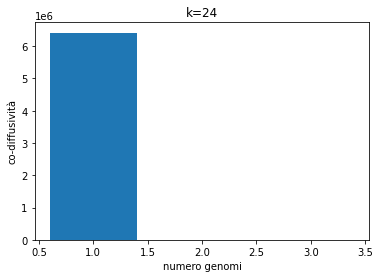

dizionario: ATC,TCA,TAC,CCG,TGG,TAA,CAG,GGT,TTC,GCG
Numero di posizioni coperte: 134
Rapporto di copertura: 0.13828689370485037
Percentuale di copertura: 13.828689370485037%


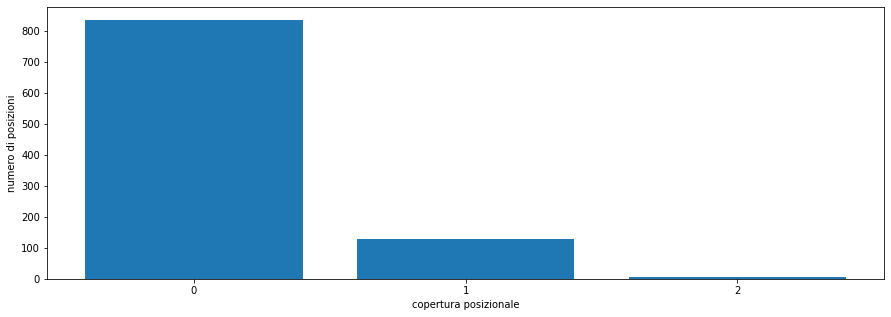

********************************************************************************
Cryptospordidium


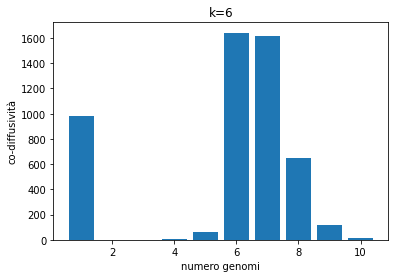

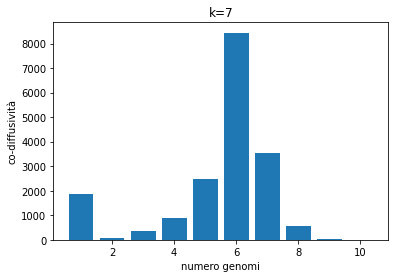

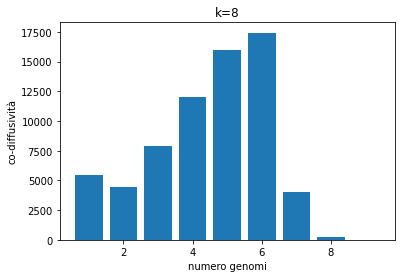

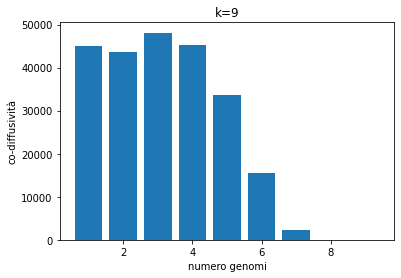

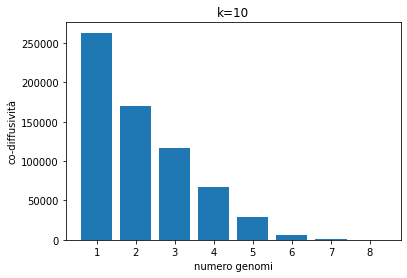

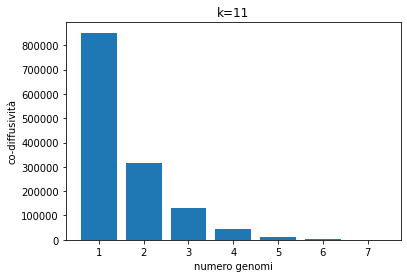

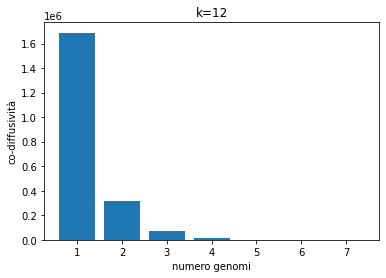

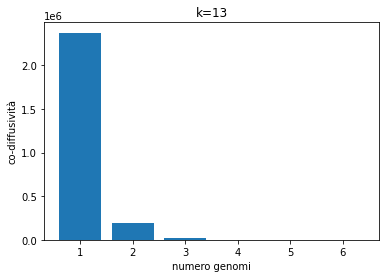

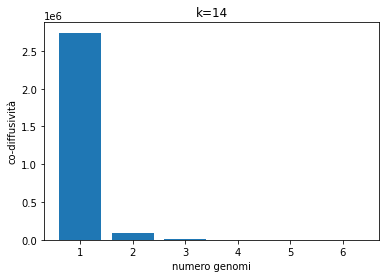

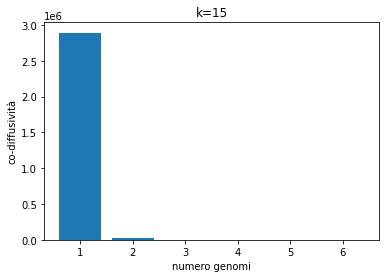

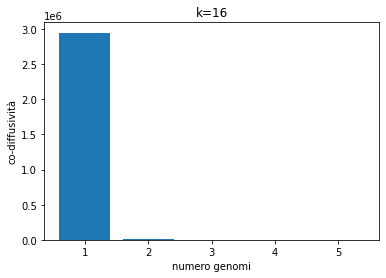

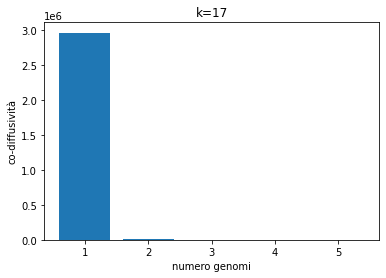

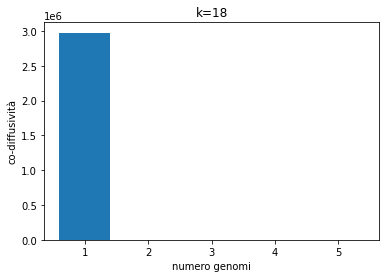

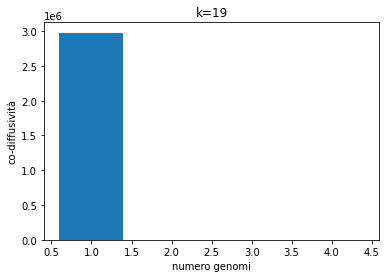

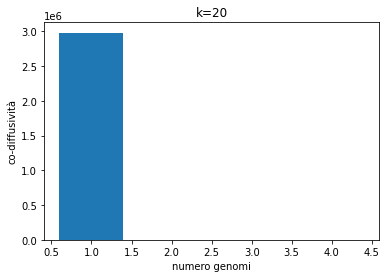

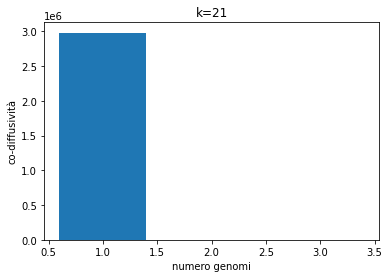

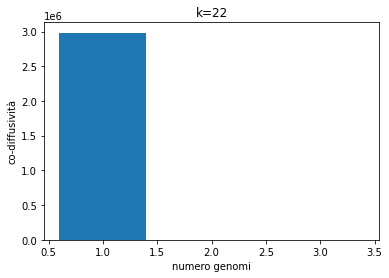

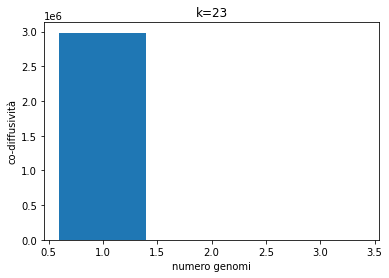

dizionario: AGC,GTG,ACC,CAA,TCG,GTG,TGA,GAG,TGG,GCT
Numero di posizioni coperte: 45225
Rapporto di copertura: 0.23725959268469263
Percentuale di copertura: 23.725959268469264%


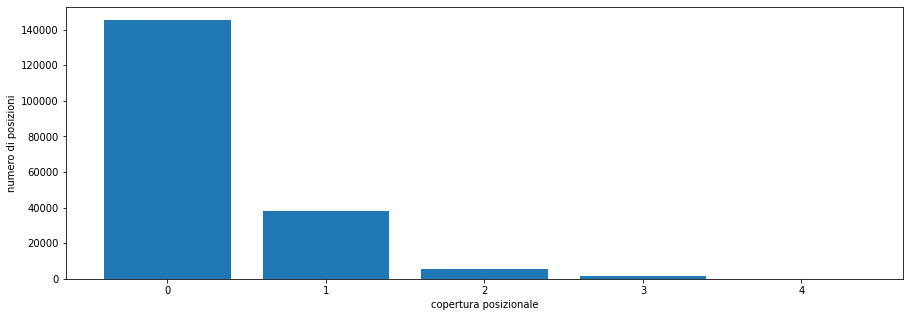

********************************************************************************
La correlazione tra k e i valori di Simpson dell Apicomplexa è:-0.787852421200805
La correlazione tra k e i valori di Simpson dell Ciliophora è:-0.9168487212939525
La correlazione tra k e i valori di Simpson dell Cryptospordidium è:-0.8889090090410099
k                       6         7         8         9         10        11  \
Apicomplexa       0.263802  0.596815  0.821658  0.874751  0.832775  0.647182   
Ciliophora        0.743250  0.603185  0.669301  0.755261  0.712942  0.589590   
Cryptospordidium  0.740487  0.715062  0.817221  0.822450  0.725516  0.540532   

k                       12        13        14        15        16        17  \
Apicomplexa       0.397152  0.239169  0.158768  0.116643  0.092552  0.077531   
Ciliophora        0.436817  0.292003  0.178444  0.100088  0.051661  0.024436   
Cryptospordidium  0.325026  0.155679  0.061795  0.021998  0.007694  0.002999   

k                       1

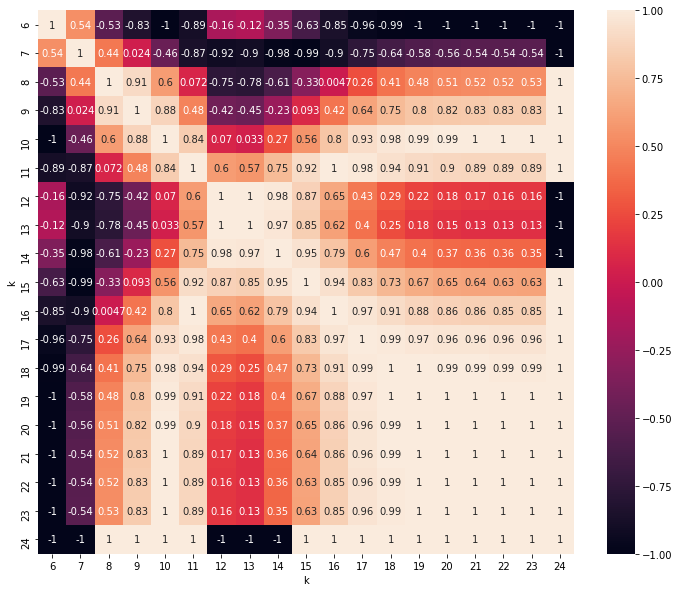

In [31]:
from pprint import pprint
import seaborn as sns
from mialibreria import *

specie1="Apicomplexa"
specie2="Ciliophora"
specie3="Cryptospordidium"

lista_sequenze=lettura_sequenze(f"./{specie1}/")
dic_codif=visualizza_co_diff(specie1,lista_sequenze)
df1=genera_df_simpson(dic_codif, specie1)
d=genera_dizionario(3)
sequenza=lista_sequenze[0]
copertura=copertura_sequenza(sequenza,d)
print('dizionario:', ",".join([w for w in d]) )
print('Numero di posizioni coperte:', copertura)
print('Rapporto di copertura:', copertura / len(sequenza))
print('Percentuale di copertura:', str((copertura / len(sequenza)) * 100)+'%'   )
visualizza_copertura(sequenza,d)
print('*'*80)

lista_sequenze=lettura_sequenze(f"./{specie2}/")
dic_codif=visualizza_co_diff(specie2,lista_sequenze)
df2=genera_df_simpson(dic_codif, specie2)
d=genera_dizionario(3)
sequenza=lista_sequenze[0]
copertura=copertura_sequenza(sequenza,d)
print('dizionario:', ",".join([w for w in d]) )
print('Numero di posizioni coperte:', copertura)
print('Rapporto di copertura:', copertura / len(sequenza))
print('Percentuale di copertura:', str((copertura / len(sequenza)) * 100)+'%'   )
visualizza_copertura(sequenza,d)
print('*'*80)

lista_sequenze=lettura_sequenze(f"./{specie3}/")
dic_codif=visualizza_co_diff(specie3,lista_sequenze)
df3=genera_df_simpson(dic_codif, specie3)
d=genera_dizionario(3)
sequenza=lista_sequenze[0]
copertura=copertura_sequenza(sequenza,d)
print('dizionario:', ",".join([w for w in d]) )
print('Numero di posizioni coperte:', copertura)
print('Rapporto di copertura:', copertura / len(sequenza))
print('Percentuale di copertura:', str((copertura / len(sequenza)) * 100)+'%'   )
visualizza_copertura(sequenza,d)
print('*'*80)

#corr tra valori dell'indice di simpson per la specie e k, tolgo k da essere indice a colonna
df_12=pd.concat([df1.T,df2.T,df3.T]).T.reset_index()
corr_Apicomplexa_k=df_12[specie1].corr(df_12["k"])
corr_Ciliophora_k=df_12[specie2].corr(df_12["k"])
corr_Cryptospordidium_k=df_12[specie3].corr(df_12["k"])

print(f"La correlazione tra k e i valori di Simpson dell Apicomplexa è:{corr_Apicomplexa_k}")
print(f"La correlazione tra k e i valori di Simpson dell Ciliophora è:{corr_Ciliophora_k}")
print(f"La correlazione tra k e i valori di Simpson dell Cryptospordidium è:{corr_Cryptospordidium_k}")
df_12.set_index("k",inplace=True)
print(df_12.T)
corr_df=df_12.T.corr()
df_12

#correlazione tra valori di simpson di un determinato k
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True)
plt.show()